In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [3]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


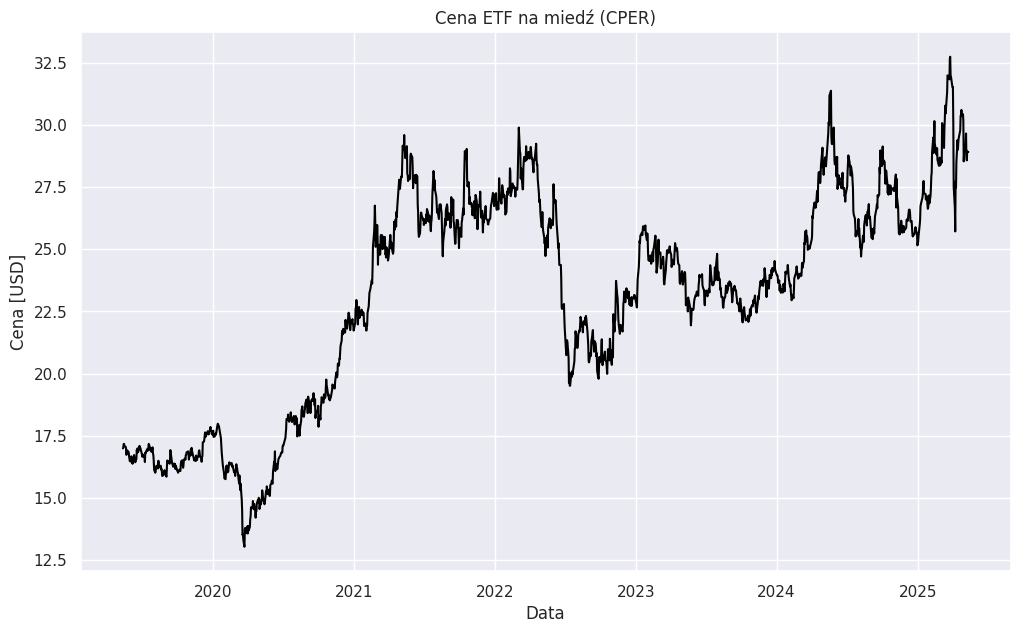

In [4]:
copper = yf.download('CPER', period='6y')['Close']

plt.plot(copper, color = 'black')
plt.title('Cena ETF na miedź (CPER)')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

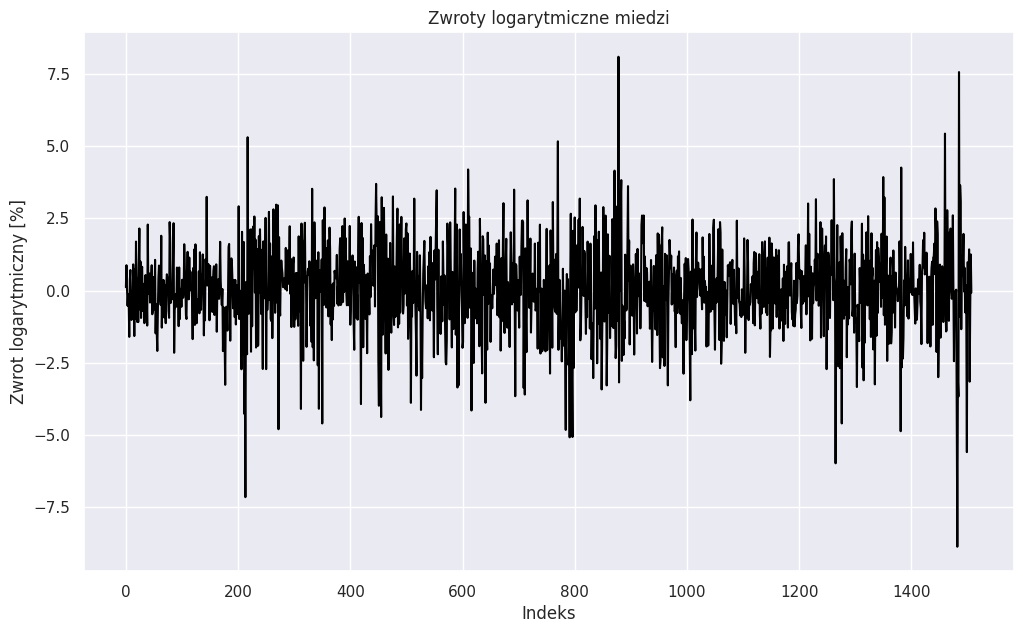

In [5]:
log_returns_copper = np.log(copper / copper.shift(1)).dropna()
log_returns_copper = 100*np.ravel(log_returns_copper)
plt.plot(log_returns_copper, color = 'black')
plt.title('Zwroty logarytmiczne miedzi')
plt.ylabel('Zwrot logarytmiczny [%]')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

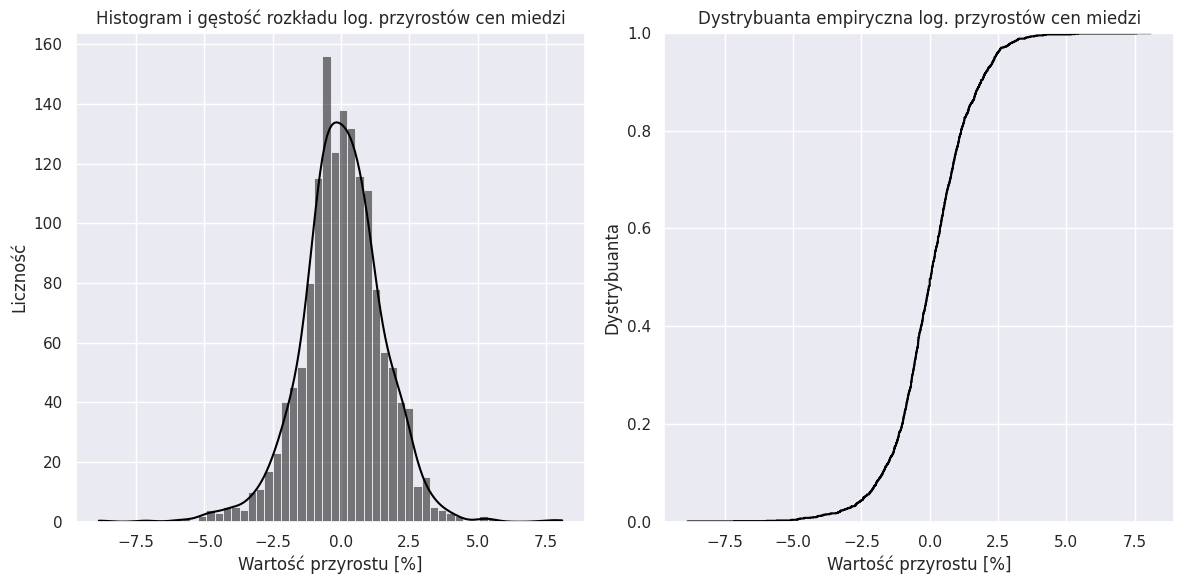

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_copper, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu [%]')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_copper, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu [%]')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

In [7]:
t_student_tests(log_returns_copper)
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

5.912770134331085 0.052347489087404254 1.2236285838218275
Test t-Studenta:
Statystyka t: -0.4404, p-wartość: 0.6597
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0175, p-wartość: 0.7385
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


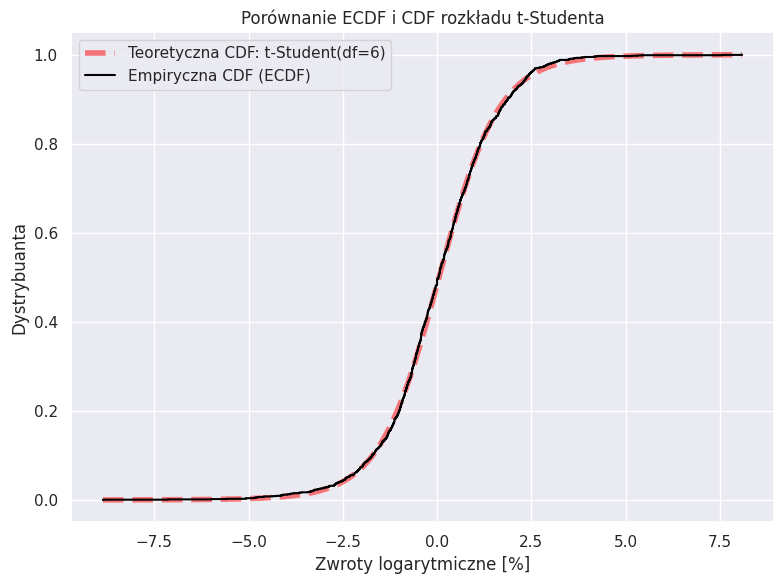

In [8]:
ecdf = ECDF(log_returns_copper)

# Siatka do wykresu
x = np.linspace(min(log_returns_copper), max(log_returns_copper), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Zwroty logarytmiczne [%]')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ZADANIE 1

## a)

Wersja chatowa :D

In [9]:
def var_parametric(series, alpha, dist='t', positive=True):
    """
    Parametric (rolling) daily VaR.
    positive=True  ➜ zwraca dodatnią liczbę straty
    positive=False ➜ zwraca wartość kwantyla (zwykle ujemną)
    """
    if dist == 't':
        df, loc, scale = st.t.fit(series)
        q = st.t.ppf(1 - alpha, df)          # lewy ogon (np. 0.05)   
        var = loc + scale * q
    else:
        mu, sigma = st.norm.fit(series)
        q = st.norm.ppf(1 - alpha)           
        var = mu + sigma * q
    return abs(var) if positive else var

In [10]:
var_parametric(log_returns_copper, 0.95), var_parametric(log_returns_copper, 0.99)

(np.float64(2.331680370104988), np.float64(3.812185274024616))

Wersja kingi

In [11]:
var_95_1 = st.t(d_f, loc, sc).ppf(0.95)
var_99_1 = st.t(d_f, loc, sc).ppf(0.99)
var_95_1, var_99_1

(np.float64(2.430078423844845), np.float64(3.897806376827956))

Poprawiona funkcja plot

In [12]:
def plot_var(values, VaR95, VaR99, title='Zwroty'):
    values = pd.Series(values)   # bezpieczne rzutowanie
    plt.figure(figsize=(16, 8))
    plt.plot(values.index, values, 'o', markersize=3, label='Zwrot')
    plt.title(title, fontsize=18)
    plt.xlabel('Obserwacja')
    plt.ylabel('Wartość')
    
    # kwantyle empiryczne
    Q95, Q99 = np.quantile(values, [0.95, 0.99])
    plt.axhline(Q95, color='k', lw=2, label=f'Q95 emp. = {Q95:.2f}')
    plt.axhline(Q99, color='brown', lw=2, label=f'Q99 emp. = {Q99:.2f}')
    
    # VaR – zakładamy, że podajesz dodatnią liczbę straty
    plt.axhline(-VaR95, color='k', ls='--', lw=2, label=f'VaR95 = {VaR95:.2f}')
    plt.axhline(-VaR99, color='brown', ls='--', lw=2, label=f'VaR99 = {VaR99:.2f}')
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Funkcja plot do histogramów - Maro kazał

In [13]:
def plot_var_hist(values, VaR95, VaR99, title='Histogram zwrotów', kde=True):
    """
    values  – 1‑D array / Series ze zwrotami (ujemne= straty)
    VaR95, VaR99 – dodatnie liczby strat (np. 2.33 oznacza -2.33 w szeregu)
    """
    values = pd.Series(values)
    plt.figure(figsize=(14, 7))
    sns.histplot(values, kde=kde, color='grey', edgecolor='black', bins=60)
    
    Q95, Q99 = np.quantile(values, [0.95, 0.99])   # empiryczne prawe ogony
    plt.axvline(Q95,  color='k',     lw=2, label=f'Q95 emp. = {Q95:.2f}')
    plt.axvline(Q99,  color='brown', lw=2, label=f'Q99 emp. = {Q99:.2f}')
    
    # VaR – rysujemy po stronie strat (ujemnie)
    plt.axvline(-VaR95, color='k',     ls='--', lw=2, label=f'VaR95 = {VaR95:.2f}')
    plt.axvline(-VaR99, color='brown', ls='--', lw=2, label=f'VaR99 = {VaR99:.2f}')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Zwrot [%]')
    plt.ylabel('Liczność')
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

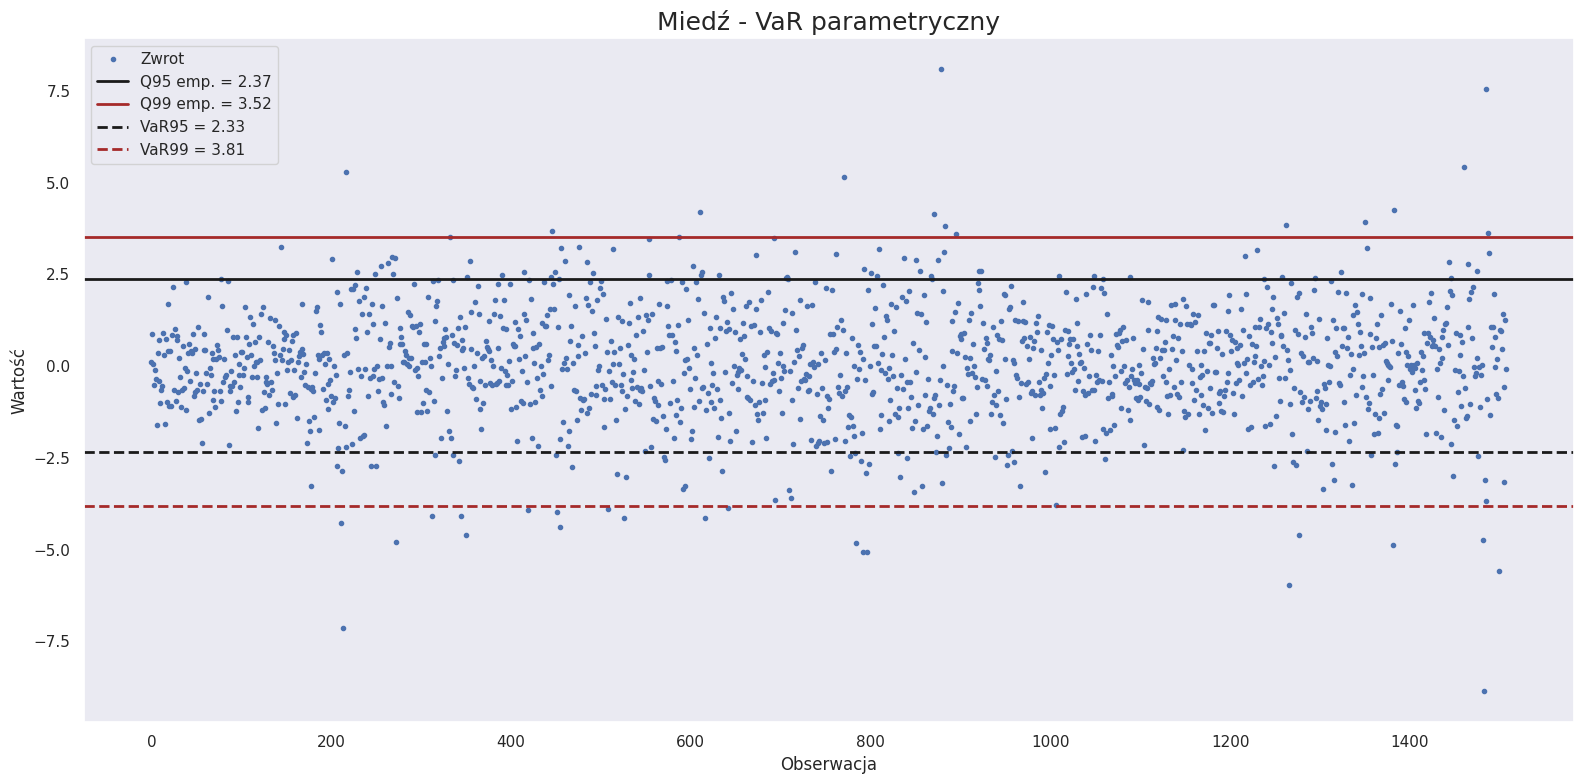

In [14]:
# kwantyle lewego ogona
VaR95 = var_parametric(log_returns_copper, 0.95, positive=True)
VaR99 = var_parametric(log_returns_copper, 0.99, positive=True)

plot_var(log_returns_copper, VaR95, VaR99,
         title='Miedź - VaR parametryczny')


histogram

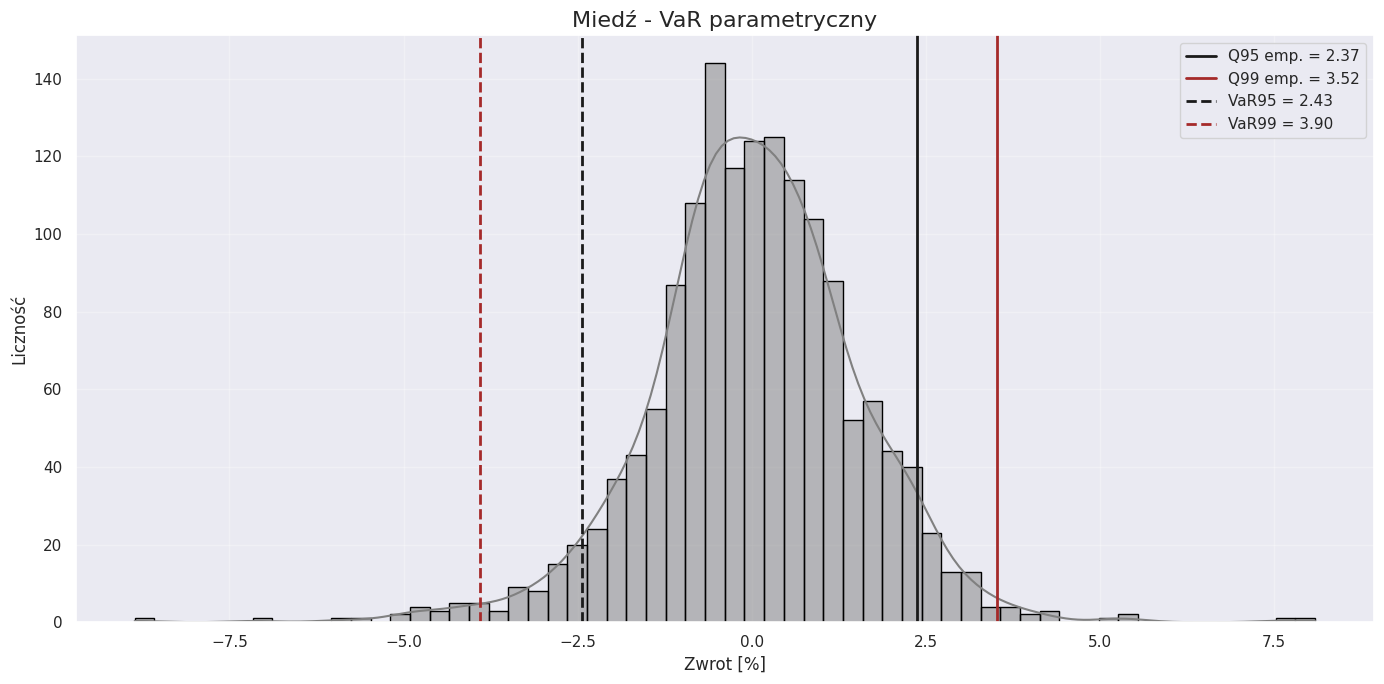

In [15]:
plot_var_hist(log_returns_copper, var_95_1, var_99_1,
              title='Miedź - VaR parametryczny')

Dlaczego empiryczny Q95 (2.37) ≠ parametryczny VaR95 (2.33)?

Empiryka bierze 5 % skrajnych danych (historia).

Parametryka używa wzoru t‑Studenta – lekko odmienny kształt ogona → delikatnie niższy VaR. Różnica kilkusetetnych % jest naturalna.

## b) 
#### i)

Mając próbkę zwrotów $(R_1, R_2, \ldots, R_t)$, obliczamy empiryczny kwantyl na poziomie $1 - \alpha$ (ozn. $q_{1-\alpha}$), to znaczy taki punkt, poniżej którego znajduje się $(1 - \alpha)\%$ obserwacji zwrotów. Wtedy wartość zagrożona (Value at Risk) przy poziomie ufności $\alpha$ wyraża się wzorem: $VaR_\alpha = -q_{1-\alpha}$

gdzie znak minus oznacza, że VaR jest wyrażony jako dodatnia liczba odpowiadająca potencjalnej stracie (ujemnemu zwrotowi).

W praktyce obliczyliśmy:

* $VaR_{95\%} = -q_{5\%}$ 
* $VaR_{99\%} = -q_{1\%}$ 



In [16]:
VaR95 = -np.quantile(log_returns_copper, 0.05)
VaR99 = -np.quantile(log_returns_copper, 0.01)
VaR95, VaR99

(np.float64(2.3996589377115023), np.float64(4.1260088353655995))

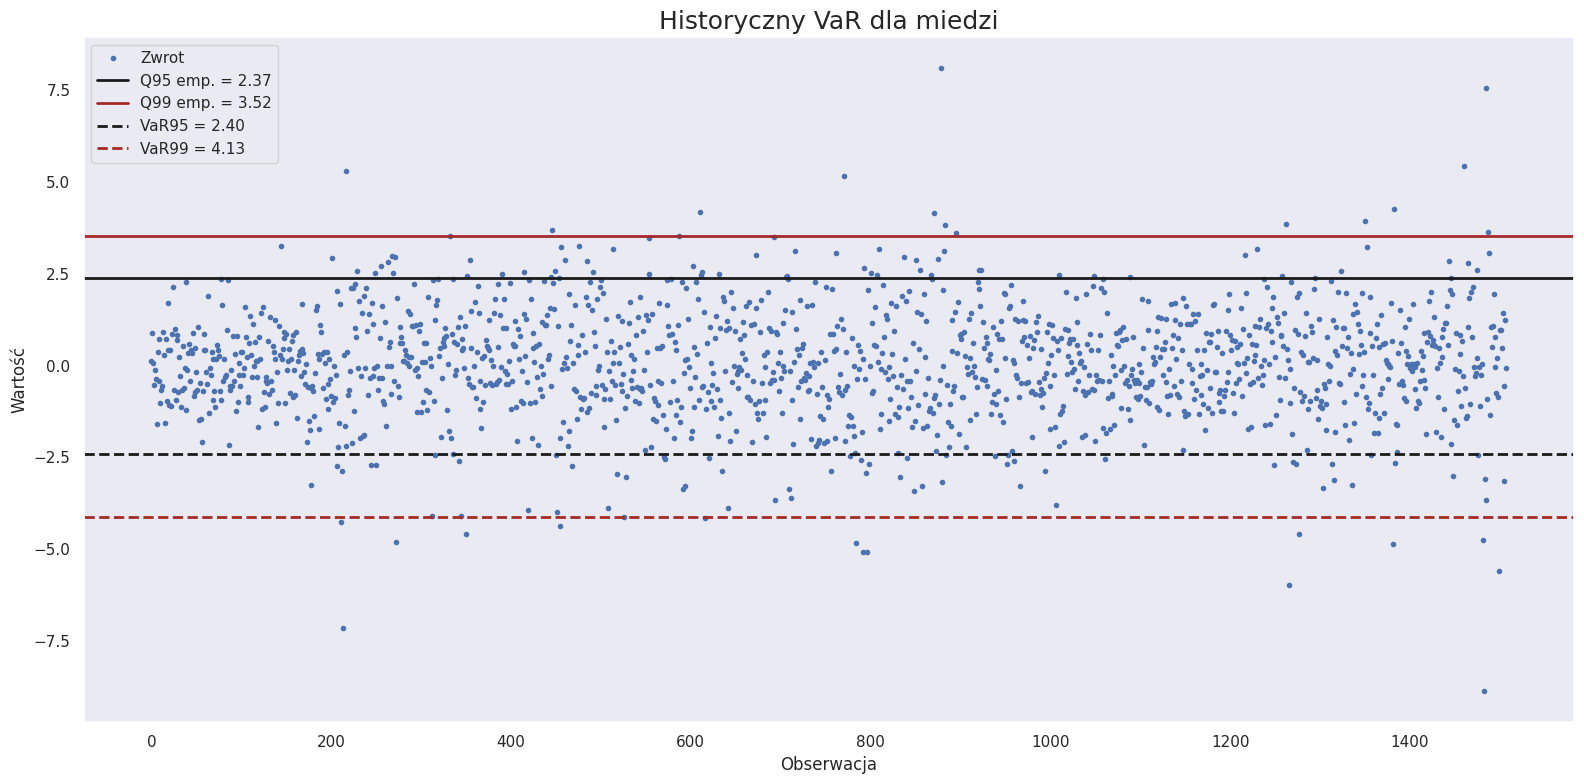

In [17]:
plot_var(log_returns_copper, VaR95, VaR99, title='Historyczny VaR dla miedzi')

histogramikowy świat

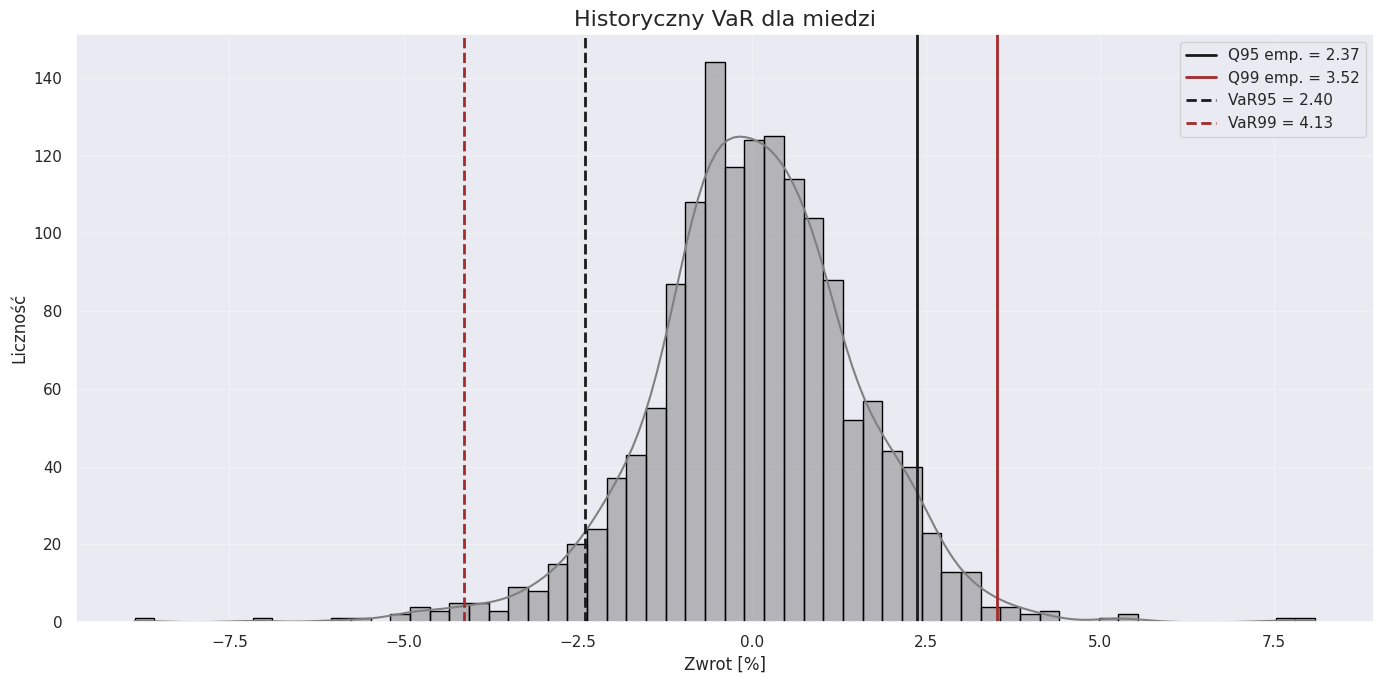

In [18]:
plot_var_hist(log_returns_copper, VaR95, VaR99, title='Historyczny VaR dla miedzi')

#### ii)

Metoda ważonej symulacji historycznej (Weighted Historical Simulation - WHS) polega na przypisaniu większych wag do bardziej aktualnych obserwacji. Jest to rozszerzenie standardowej metody symulacji historycznej, które pozwala lepiej uwzględnić zmienne warunki rynkowe.

W metodzie tej wprowadzamy system wag, w którym najnowsze obserwacje mają większy wpływ na wynik niż obserwacje dawniejsze. Wagi określamy przy użyciu parametru $\lambda$ (lambda), który przyjmuje wartości z przedziału $(0,1)$. Typowa wartość $\lambda$ to 0.97-0.99.

Podstawą metody jest następujący system wag:

$$w_t = \frac{(1-\lambda)\lambda^{t-1}}{\sum_{i=1}^{T}(1-\lambda)\lambda^{i-1}} = \frac{(1-\lambda)\lambda^{t-1}}{1-\lambda^T}$$

gdzie:
- $w_t$ to waga dla obserwacji $t$ (licząc od najnowszej)
- $\lambda$ to parametr spadku wagi (decay factor)
- $T$ to liczba wszystkich obserwacji

Dla dużych $T$ mianownik dąży do 1, więc można stosować uproszczoną formułę:

$$w_t \approx (1-\lambda)\lambda^{t-1}$$

In [31]:
# Funkcja do obliczania wag dla metody ważonej symulacji historycznej
def oblicz_wagi(n, lambda_param=0.97):
    """
    Oblicza wagi dla metody ważonej symulacji historycznej.
    
    Parametry:
    - n: liczba obserwacji
    - lambda_param: parametr wygładzania (domyślnie 0.97)
    
    Zwraca:
    - wagi: wektor wag dla każdej obserwacji
    """
    wagi = np.zeros(n)
    for i in range(n):
        wagi[i] = (1 - lambda_param) * lambda_param**i
    
    # Normalizacja wag, aby suma wynosiła 1
    wagi = wagi / wagi.sum()
    
    return wagi

Mając obliczone wagi, możemy przystąpić do obliczenia ważonego kwantyla, który posłuży nam do wyznaczenia VaR. Ważony kwantyl rzędu $\alpha$ dla szeregu danych $(x_1, x_2, ..., x_n)$ z przypisanymi wagami $(w_1, w_2, ..., w_n)$ definiujemy następująco:

1. Sortujemy pary $(x_i, w_i)$ względem wartości $x_i$ (od najmniejszej do największej)
2. Obliczamy skumulowane wagi $cw_i = \sum_{j=1}^{i} w_j$
3. Ważony kwantyl rzędu $\alpha$ to najmniejsza wartość $x_i$, dla której $cw_i \geq \alpha$

W praktyce, do wyznaczenia VaR na poziomie ufności $\alpha$ przy pomocy metody ważonej symulacji historycznej, należy wyznaczyć ważony kwantyl rzędu $(1-\alpha)$ dla szeregu stóp zwrotu.

In [34]:
def kwantyl_wazony(dane, wagi, alpha):
    """
    Oblicza ważony kwantyl dla danych z przypisanymi wagami.
    
    Parametry:
    - dane: szereg danych
    - wagi: wektor wag odpowiadających danym
    - alpha: poziom kwantyla (np. 0.05 dla 5% kwantyla)
    
    Zwraca:
    - kwantyl: ważony kwantyl rzędu alpha
    """
    # Sortowanie danych i wag według wartości danych
    idx = np.argsort(dane)
    sorted_dane = dane[idx]
    sorted_wagi = wagi[idx]
    
    # Obliczanie skumulowanych wag
    cum_wagi = np.cumsum(sorted_wagi)
    
    # Znalezienie indeksu, dla którego skumulowana waga przekracza alpha
    j = np.argmax(cum_wagi >= alpha)
    
    return sorted_dane[j]

Mając zdefiniowane funkcje pomocnicze, możemy przystąpić do implementacji metody VaR z wykorzystaniem ważonej symulacji historycznej. 

Algorytm obliczania VaR metodą ważonej symulacji historycznej można przedstawić następująco:

1. Dla danego szeregu czasowego logarytmicznych stóp zwrotu $(r_1, r_2, ..., r_T)$, gdzie $r_1$ jest najnowszą obserwacją, obliczamy wagi $(w_1, w_2, ..., w_T)$ przy użyciu parametru $\lambda$
2. Wyznaczamy ważony kwantyl rzędu $(1-\alpha)$ dla szeregu stóp zwrotu z przypisanymi wagami
3. VaR na poziomie ufności $\alpha$ jest równy wartości bezwzględnej tego kwantyla (ze znakiem minus, jeśli kwantyl jest ujemny)

Ta metoda, w przeciwieństwie do zwykłej symulacji historycznej, pozwala na lepsze odzwierciedlenie aktualnych warunków rynkowych, przypisując większą wagę do najnowszych obserwacji. Dzięki temu VaR szybciej reaguje na zmiany w zmienności rynku.

In [43]:
# Funkcja do obliczania VaR metodą ważonej symulacji historycznej
def var_wazony_symulacja_historyczna(returns, alpha, lambda_param=0.97):
    """
    Oblicza Value at Risk metodą ważonej symulacji historycznej.
    
    Parametry:
    - returns: szereg zwrotów (stóp zwrotu)
    - alpha: poziom ufności (np. 0.95 lub 0.99)
    - lambda_param: parametr wygładzania (domyślnie 0.97)
    
    Zwraca:
    - VaR: wartość narażona na ryzyko
    """
    # Odwracamy kolejność zwrotów (najnowsze obserwacje jako pierwsze)
    returns_reversed = returns[::-1]
    
    # Obliczamy wagi dla każdej obserwacji
    wagi = oblicz_wagi(len(returns_reversed), lambda_param)
    
    # Obliczamy ważony kwantyl, który odpowiada VaR
    var = -kwantyl_wazony(returns_reversed, wagi, 1-alpha)
    
    return var

##### $\lambda = 0.97$

VaR dla miedzi metodą ważonej symulacji historycznej:
VaR 95%: 4.741151
VaR 99%: 8.861496


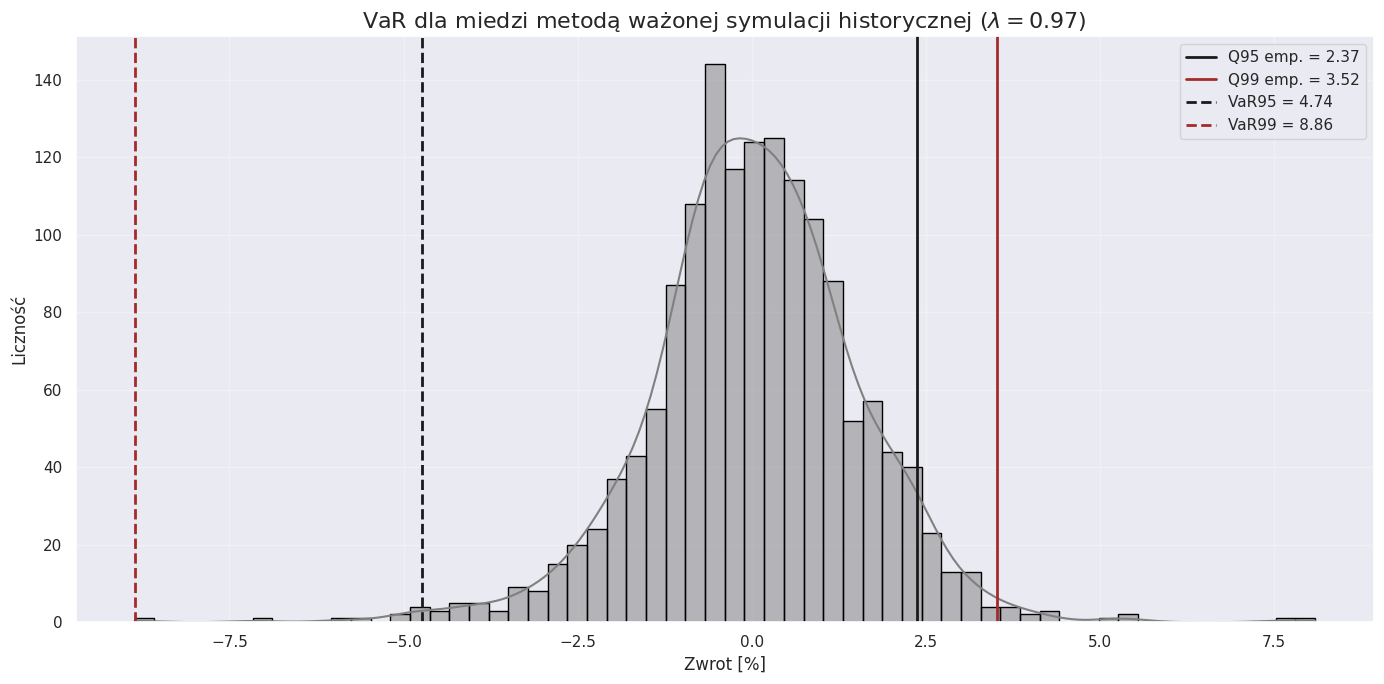

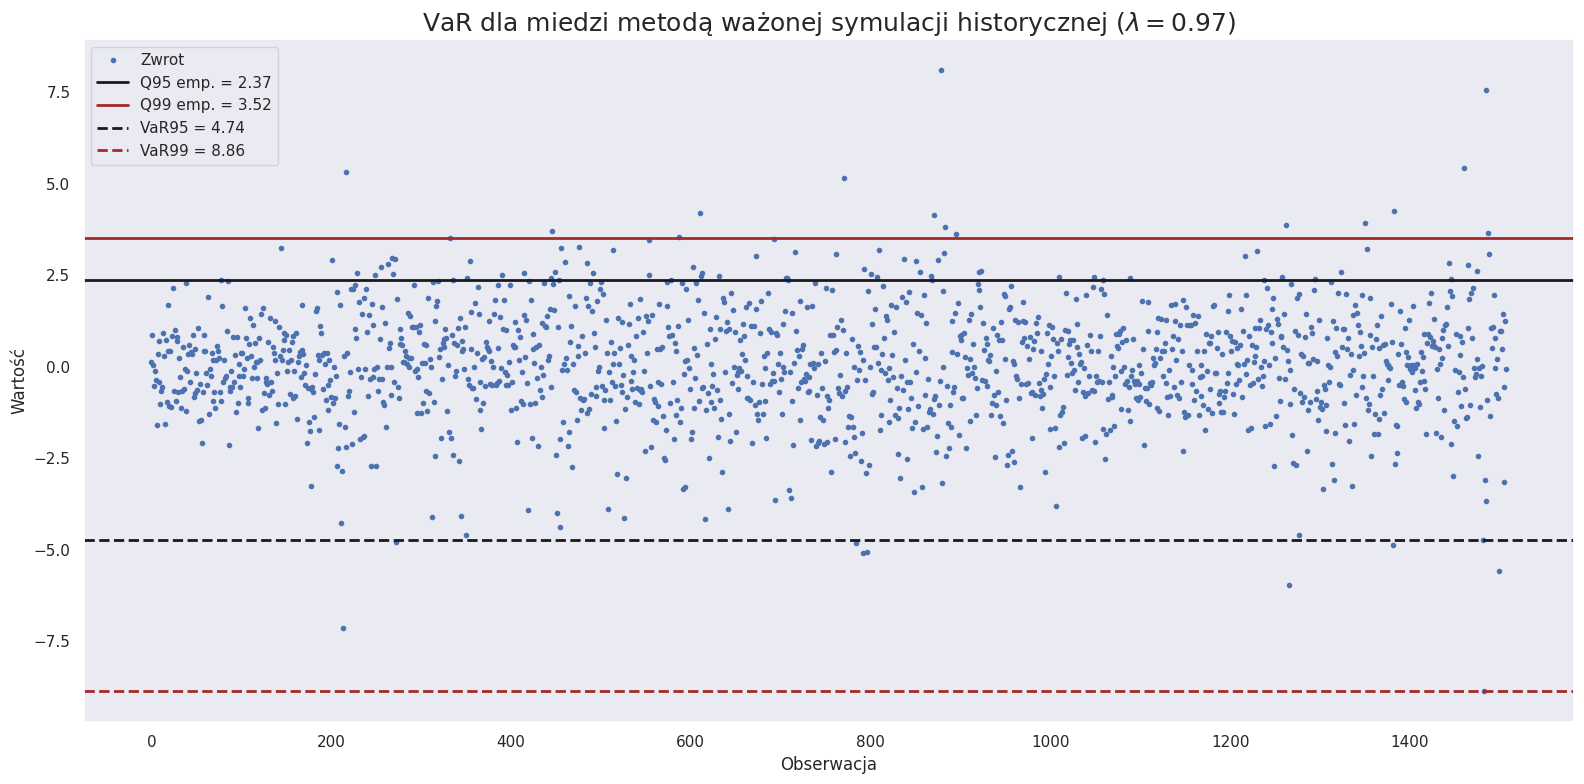

In [50]:
# Obliczenie VaR dla przedziałów ufności 95% i 99%
lambda_param = 0.97  # parametr wygładzania
VaR95_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.95, lambda_param)
VaR99_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.99, lambda_param)

print("VaR dla miedzi metodą ważonej symulacji historycznej:")
print(f"VaR 95%: {VaR95_wazony:.6f}")
print(f"VaR 99%: {VaR99_wazony:.6f}")

# Wizualizacja wyników - histogram z zaznaczonymi wartościami VaR
plot_var_hist(log_returns_copper, VaR95_wazony, VaR99_wazony, 
              title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.97$)')

# Wizualizacja wyników - wykres szeregu czasowego z zaznaczonymi wartościami VaR
plot_var(log_returns_copper, VaR95_wazony, VaR99_wazony, 
         title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.97$)')

##### $\lambda = 0.99$

VaR dla miedzi metodą ważonej symulacji historycznej:
VaR 95%: 3.150946
VaR 99%: 5.587282


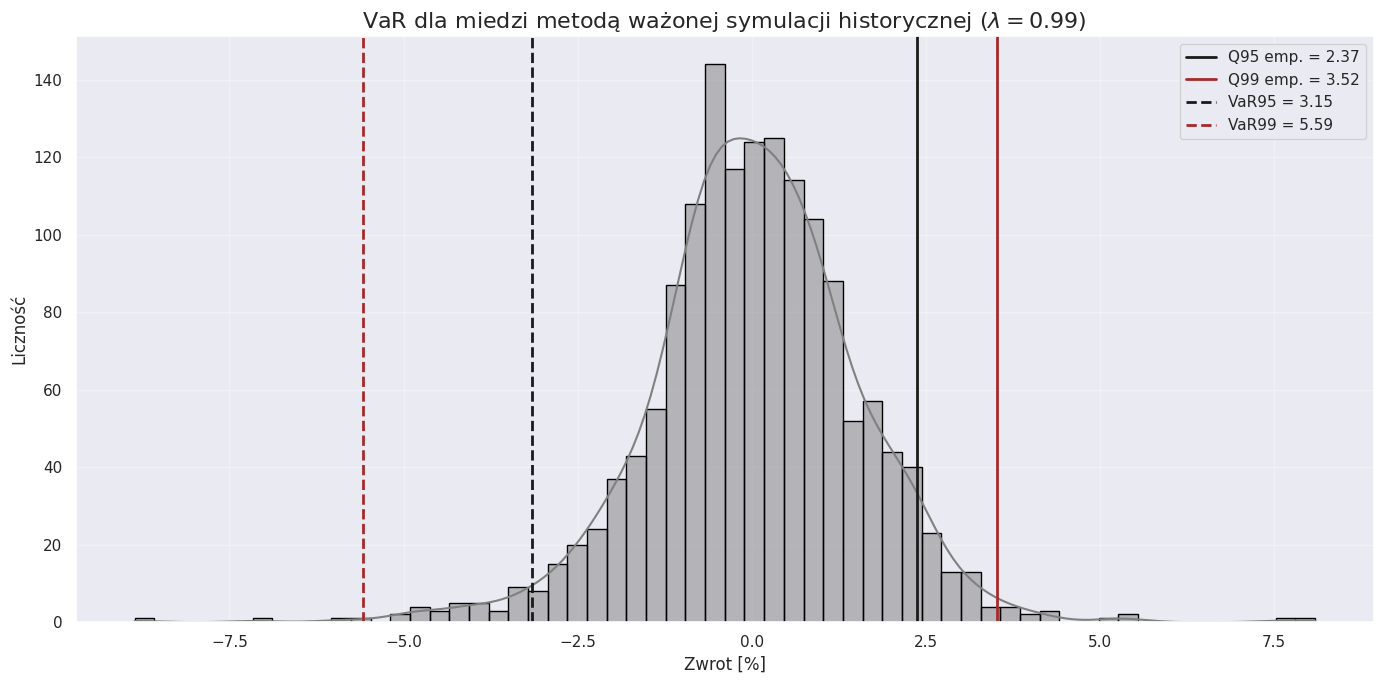

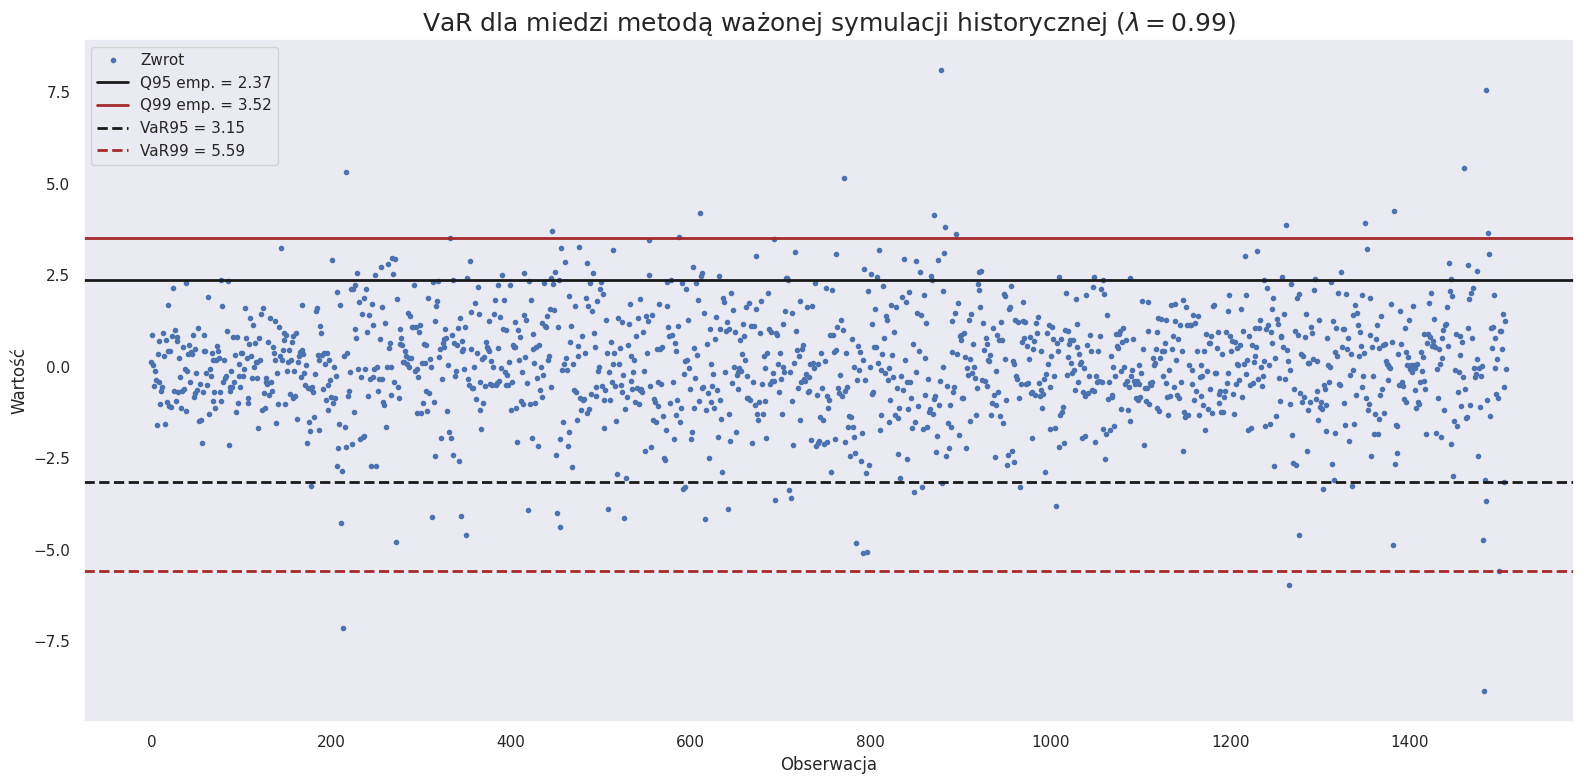

In [49]:
# Obliczenie VaR dla przedziałów ufności 95% i 99%
lambda_param = 0.99  # parametr wygładzania
VaR95_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.95, lambda_param)
VaR99_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.99, lambda_param)

print("VaR dla miedzi metodą ważonej symulacji historycznej:")
print(f"VaR 95%: {VaR95_wazony:.6f}")
print(f"VaR 99%: {VaR99_wazony:.6f}")

# Wizualizacja wyników - histogram z zaznaczonymi wartościami VaR
plot_var_hist(log_returns_copper, VaR95_wazony, VaR99_wazony, 
              title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.99$)')

# Wizualizacja wyników - wykres szeregu czasowego z zaznaczonymi wartościami VaR
plot_var(log_returns_copper, VaR95_wazony, VaR99_wazony, 
         title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.99$)')

##### Wnioski

Metoda ważonej symulacji historycznej została zastosowana z różnymi wartościami parametru λ, uzyskując następujące wyniki:

| Parametr λ | VaR 95% | VaR 99% |
|------------|---------|---------|
| 0.97       | 4.74%   | 8.86%   |
| 0.99       | 3.15%   | 5.59%   |

Dla porównania, metoda zwykłej symulacji historycznej (1.b.i) dała wyniki:
- VaR 95%: 2.40%
- VaR 99%: 4.13%

**Wpływ parametru λ:**
- **λ = 0.97** - szybki spadek wag powoduje większą wrażliwość na najnowsze dane, prowadząc do znacznie wyższych oszacowań VaR
- **λ = 0.99** - wolniejszy spadek wag daje wyniki bliższe metodzie zwykłej, ale wciąż bardziej konserwatywne

Metoda ważonej symulacji historycznej przypisuje większe znaczenie najnowszym obserwacjom, co może lepiej odzwierciedlać aktualne warunki rynkowe, szczególnie w okresach zmian trendów czy zmienności.

Z perspektywy zarządzania ryzykiem dla miedzi, parametr λ = 0.99 wydaje się bardziej odpowiedni, dając podwyższone oszacowania VaR w stosunku do metody zwykłej, ale nie tak drastycznie jak przy λ = 0.97.

Wyższe wartości VaR uzyskane tą metodą sugerują utrzymywanie większych buforów kapitałowych, co zwiększa bezpieczeństwo, ale może ograniczać potencjalne zyski.

#### iii)

## c)

In [19]:
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=100000, random_state=1)

VaR95 = -np.percentile(simulated_returns, 5)
VaR99 = -np.percentile(simulated_returns, 1)
VaR95, VaR99

(np.float64(2.300359209575977), np.float64(3.7417763147029746))

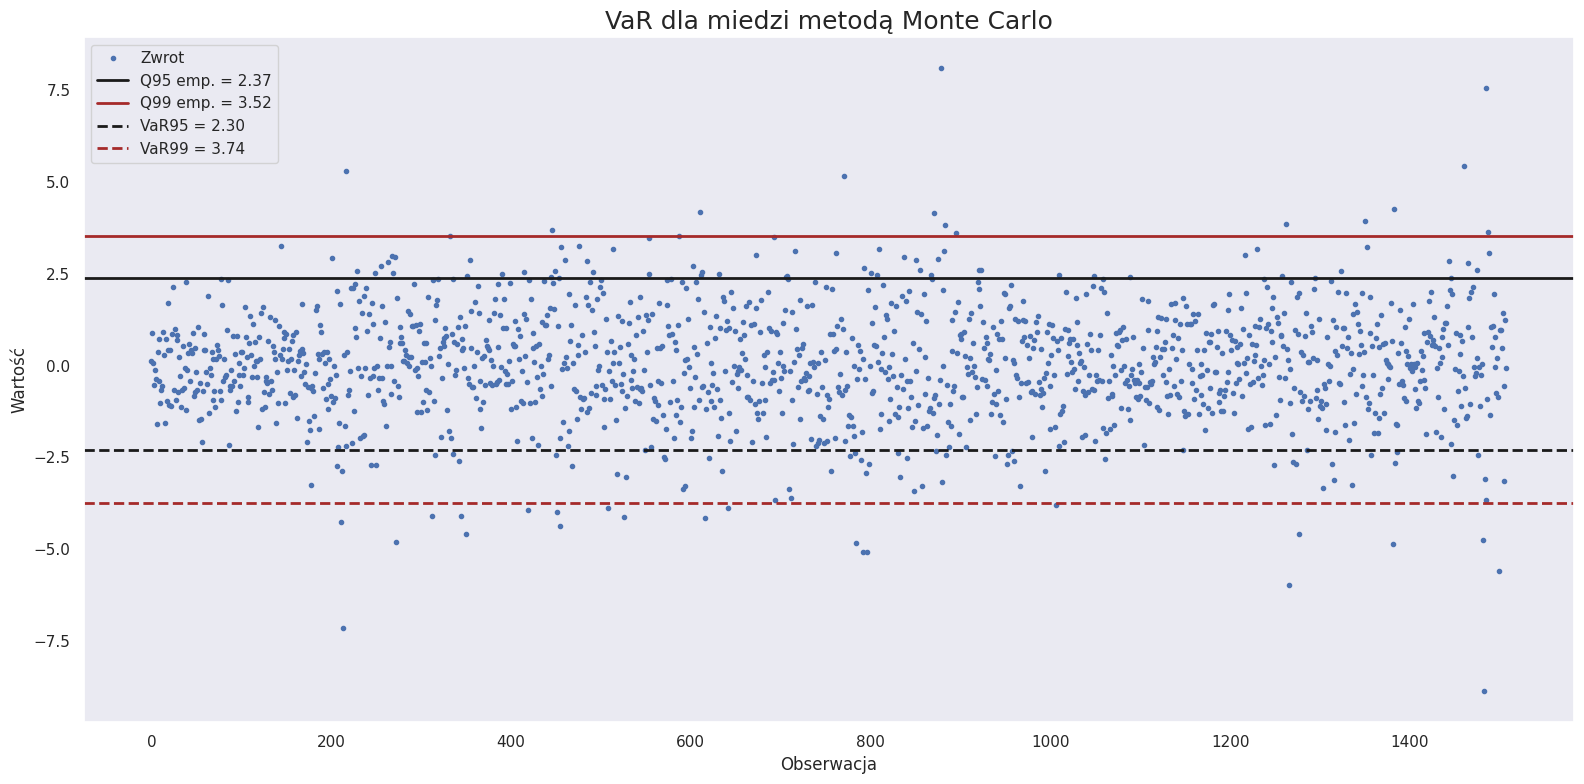

In [20]:
plot_var(log_returns_copper, VaR95, VaR99, title='VaR dla miedzi metodą Monte Carlo')

gramhisto

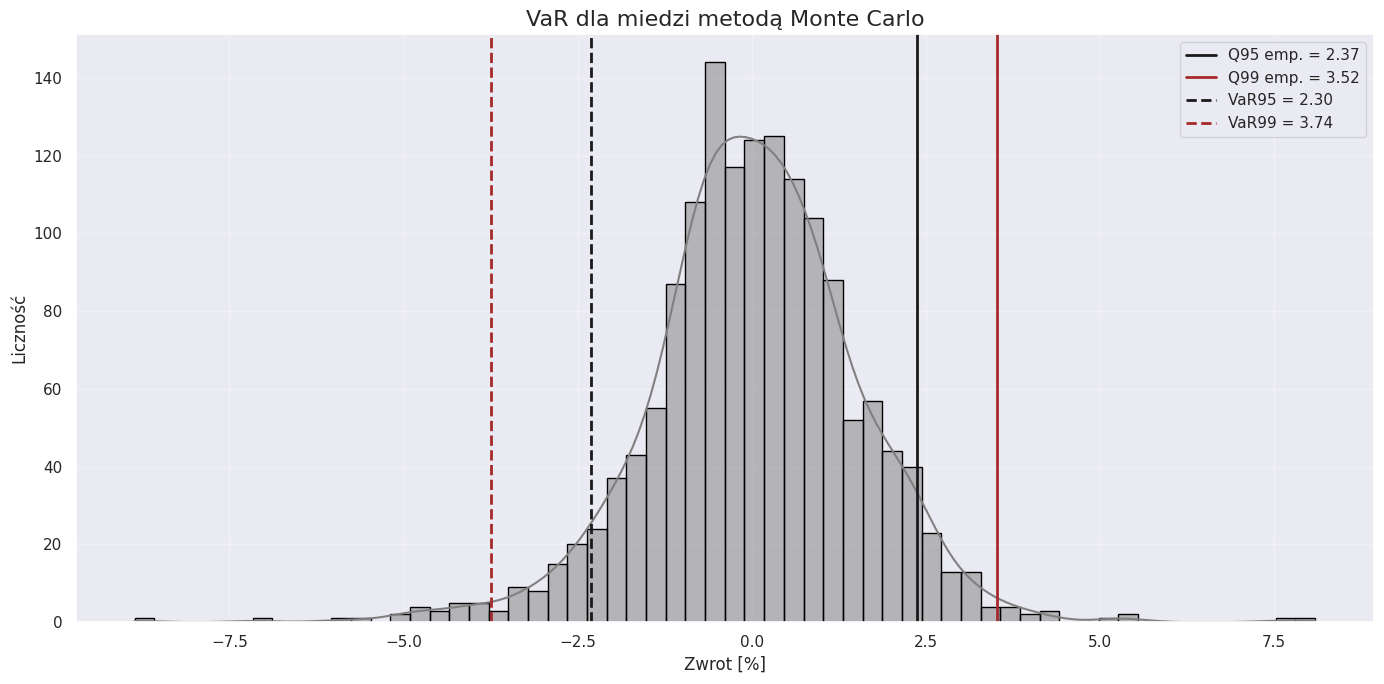

In [21]:
plot_var_hist(log_returns_copper, VaR95, VaR99, title='VaR dla miedzi metodą Monte Carlo')

# Zadanie 2

In [22]:
def backtesting(alpha, data, method, *method_parameters):
    n = len(data) // 2
    results = np.zeros(n)
    data = np.array(data)
    for i in range(n):
        VaR = method(data[i:n + i], alpha, *method_parameters)
        results[i] = int(data[n + i] < VaR)
    return results

# a)

In [23]:
def var_parametric(data, alpha, *args):
    return st.t(*st.t.fit(data)).ppf(alpha)

a_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_parametric)
a_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_parametric)

print('Porównanie średnich z rozkładem Bernoulliego:')
print('0.95:', np.mean(a_wektor_przekroczen_95))
print('0.99:', np.mean(a_wektor_przekroczen_99))

print('\nPorównanie wariancji z rozkładem Bernoulliego:')
print(f'{0.95 * 0.05}:', np.var(a_wektor_przekroczen_95, ddof=1))
print(f'{0.99 * 0.01}:', np.var(a_wektor_przekroczen_99, ddof=1))


Porównanie średnich z rozkładem Bernoulliego:
0.95: 0.9602122015915119
0.99: 0.9893899204244032

Porównanie wariancji z rozkładem Bernoulliego:
0.0475: 0.03825546619886502
0.0099: 0.010511446697736024


## b)
#### i)

In [24]:
def var_historical(data, alpha):
    VaR = -np.quantile(data, (1 - alpha))
    return VaR

b1_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_historical)
b1_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_historical)

print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))


Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9907161803713528
0.95: 0.9562334217506632

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.00920984497025162
0.0475: 0.04190664398110475


#### ii)

#### iii)

## c)

In [25]:
def backtesting(alpha, data):
    n = len(data) // 2
    results = np.zeros(n)
    data = np.array(data)
    d_f, loc, sc = st.t.fit(data)
    d_f = 6  

    simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=100000, random_state=1)
    
    for i in range(n):
        VaR = -np.percentile(simulated_returns, (1 - alpha) * 100)
        results[i] = int(data[n + i] < VaR)
    
    return results

c_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper)
c_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper)

# Obliczenia wyników
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(c_wektor_przekroczen_99))
print("0.95:", np.mean(c_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(c_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(c_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9880636604774535
0.95: 0.9442970822281167

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.01180952582243968
0.0475: 0.05266995677766389
